- Limpiar la data de valores nulos

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno #Para graficar mis nulos
import gc
import warnings

warnings.filterwarnings('ignore') #Para que no me salgan caveats
gc.collect() #Como garbage cleaner
df = pd.read_csv('data_pseudo_limpia2.csv')
pd.set_option('display.max_columns',None) #Para ver todas mis columnas...

In [7]:
df['latitud'] = df['latitud']*-1

In [8]:
#Eliminaré las variables que no tienen data en sí.
df.drop(['EsCondominio'], inplace = True, axis=1)
df.drop(['NoTieneAlgunDatoExtra'],inplace=True,axis=1)
df.drop(['Area_Terreno'],inplace=True,axis=1)

In [9]:
cols = df.columns
print(*cols)

Unnamed: 0 Antiguedad Anunciante Balneario NroBanios Nro_pisos Cocheras Descripcion Direccion Disposicion Dormitorios Estado de Inmueble Fecha_pub Fila Fondo Frente Luminosidad Mantenimiento Mascotas Medidas Pisos_construibles TipoPuertaCochera Precio Referencia Tipo TipoCochera Ubicacion Urbaniz Uso_comercial Uso_profesional latitud longitud Area_constr Area_total Area_constr_m2 Area_total_m2 Area_Terreno_m2 match 'Cuarto de servicio' 'Deposito' 'Terraza' 'Kitchenette' 'Sala de estar' 'Sotano' 'Patio' 'anx81tico' 'Comedor diario' 'Comedor' 'Banio de servicio' 'Jardanxadn Interno' 'Walking Closet' 'Escritorio' 'Cocina' 'Banio independiente' 'Lavanderanxada' 'Balcon' 'Sala' 'Closet' 'Banio de visitas' 'Agua' 'Guardiananxada' 'Internet' 'Luz' 'Cable' 'Servicio de Limpieza' 'Conexion a gas' 'Sistema de seguridad' 'Telefono' 'Areadeportiva' 'Piscina' 'Solarium' 'Sala de internet' 'Sala de cine' 'Jardanxadn' 'Parque interno' 'Guarderanxada' 'anx81reas verdes' 'Club House' 'Hall de ingreso' 

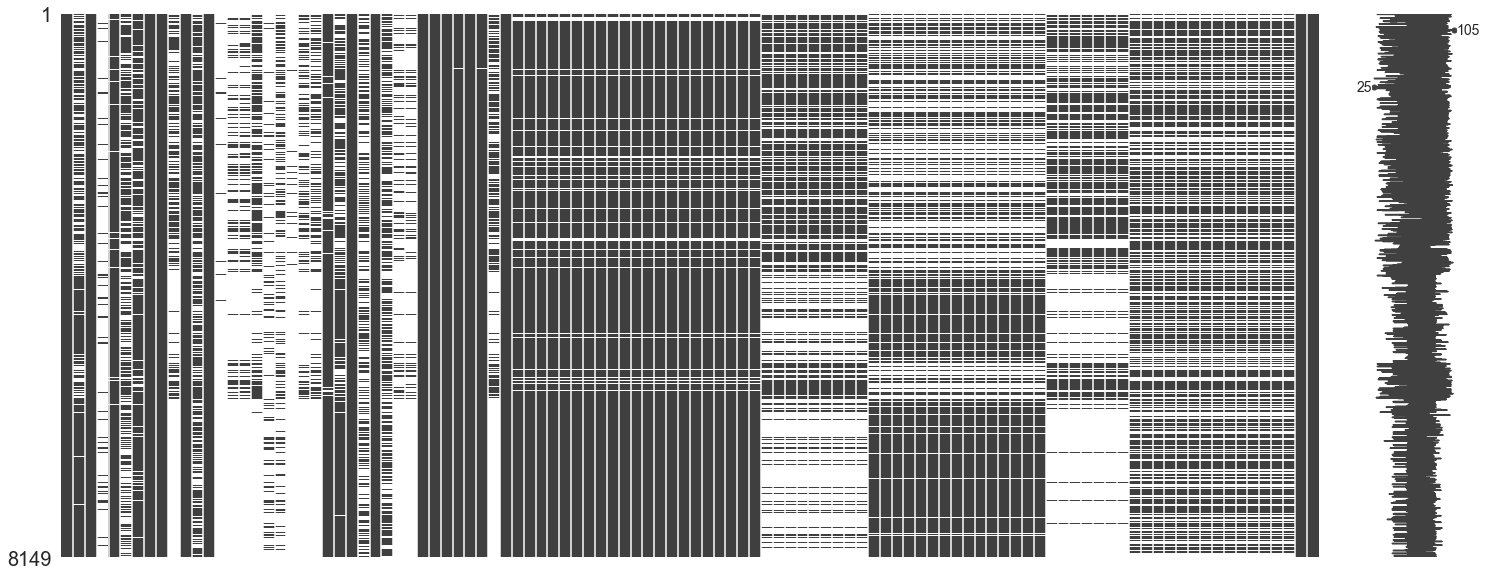

In [10]:
sns.set(style='whitegrid')
msno.matrix(df)

La variable "Balneario" nos dice en qué balneario está nuestra CASA DE PLAYA. Por lo tanto, revisaré si es que todas las casas de Playa tienen esta variable. Sino, reemplazo esos nulos por un "NoEspecifica". Y las casas normales las cambiaré por "NoEsCasaPlaya"  

In [11]:
#Reemplazo los valores nulos de Balneario
df.loc[(df['Balneario'].isna()) & (df['Tipo'] == 'Casa de Playa'),'Balneario'] = 'NoEspecifica'
df.loc[(df['Balneario'].isna()),'Balneario'] = 'Nulo'

Como algunos datos faltantes pueden encontrarse dentro de 'Descripcion', procederemos a standarizar todo descripción y buscar dentro de ella. Para eso, tendremos que reemplazar los valores que no son utf-8 y, a su vez, poner todo en letras minúsculas.

In [12]:
#PODEMOS BUSCAR LA INFO QUE NO ENCONTREMOS DENTRO DE DESCRIPCION
df['Descripcion'] = df['Descripcion'].str.lower() #Convierto todos los strings de la columna en minúsuculas.

In [13]:
o = df[df['Descripcion'].str.contains(' anios')]
o['Antiguedad'].isna() #Como solo hay 94 datos que se pueden reemplazar. Por ahora solo haré el reemplazo dsde la media.

#Reemplazaré Antiguedad por su media.

#OJO, hay casas MAS antiguas que no necesariamente tienen esta edad

##ESta no puede ser la solución más optima, pero opto por hacerla por fines prácticos.
df['Antiguedad'].fillna(int(df.Antiguedad.mean()),inplace=True)

In [14]:
##Nos encargaremos del nro de Banios. LLenaremos con la moda los valores nulos
#sns.countplot(x='NroBanios',data=df)
print(df['NroBanios'].isna().sum())
df['NroBanios'].fillna(5.0,inplace=True)

252


In [15]:
#Hay 3236 nulos en la var Nro_pisos, entonces veremos.
#Tenemos outliers, numero 33 y 44. así como 28... Los explorare,os
df[df['Nro_pisos'] == 33] #Dato erroneo, quiso decir 3 pisos
df[df['Nro_pisos'] == 44] #Dato erroneo, quiso decir 4 pisos
df[df['Nro_pisos'] == 28] #Dato erroneo, quiso decir 2 pisos
dict_r_pisos = {33:3,44:3,28:2}
for word,replace in dict_r_pisos.items():
    df['Nro_pisos'] = df['Nro_pisos'].replace(word,replace)

In [16]:
df[df['Nro_pisos'] == 8] #El de index 4671 sí tiene 8 pisos, mientras que el 6705 tiene 4. 
df.loc[df['Unnamed: 0'] == 7200, 'Nro_pisos'] = 4 #Reemplazo el valor

In [17]:
#Voy a reemplazar Disposición como esquina, buscando dentro de la descripción tal palabra. 
df.loc[(df['Descripcion'].str.contains('esquina')) & (df['Disposicion'].isna()),'Disposicion'] = 'Esquina' #Lista de columnas a reemplazar

###### Antes de continuar reemplazando los valores nulos, quisiera definir bien qué es lo que entiendo por las diferentes variables que hay
###### dentro de este dataset. Específicamente en Area_Terreno_m2, Area_constr_m2 y Area_total_m2.  Su diferencia y posible uso.

Area_Terreno_m2: Sería exactamente el área del terreno que se vende. Puede ser menor que el Area total y el Area Construida.

Area_constr_m2: Es el Area construida, depende del número de pisos que tenga la edificación.

Area_total_m2: Es el area construida mas el area que no se ha contado en la construccion, es decir, si tenemos una casa con
               
               2pisos y 1patio,entonces el Area_total_m2 será la suma del area del patio + area del piso 1 + area del piso2


In [18]:
#Acá estoy asumiendo que las casas con un solo piso, tienen la misma area de terreno y area total. Por lo tanto, reemplazo
#los valores nulos de Area_Terreno_m2 de esa forma. 
df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_Terreno_m2'] = df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_total_m2']

#Asimismo, reemplazaré los que tienen Area_total y Area_terreno igual como si fueran de un piso en los nulos de Nro_pisos


In [19]:
prueba = df[['Area_Terreno_m2','Area_constr_m2','Area_total_m2','Nro_pisos']]
print(prueba.Area_Terreno_m2.isna().sum())
print(prueba.Area_constr_m2.isna().sum())
print(prueba.Area_total_m2.isna().sum())

4741
7
8


#### Se ha optado por reemplazar los valores nulos de nro de pisos buscando dentro de la Descripción cuántos pisos hay

In [20]:
#df.groupby('Anunciante').count().sort_values(['Unnamed: 0','Nro_pisos'],ascending=False) #Para ver qué empresas ponen más nulos

#Primero veremos cuántos casos hay dentro de esta solución (¿Cuántos problemas no solucionaría?)
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
df[((df['Descripcion'].str.contains('|'.join(buscar_pisos))) & (df['Nro_pisos'].isna()))].head()

,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,Urbaniz,Uso_comercial,Uso_profesional,latitud,longitud,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Cuarto de servicio','Deposito','Terraza','Kitchenette','Sala de estar','Sotano','Patio','anx81tico','Comedor diario','Comedor','Banio de servicio','Jardanxadn Interno','Walking Closet','Escritorio','Cocina','Banio independiente','Lavanderanxada','Balcon','Sala','Closet','Banio de visitas','Agua','Guardiananxada','Internet','Luz','Cable','Servicio de Limpieza','Conexion a gas','Sistema de seguridad','Telefono','Areadeportiva','Piscina','Solarium','Sala de internet','Sala de cine','Jardanxadn','Parque interno','Guarderanxada','anx81reas verdes','Club House','Hall de ingreso','Areade BBQ','Gimnasio','Areade sauna','Juegos para ninios','Ingreso independiente','Colegios cercanos','Cerca al mar','Centros comerciales cercanos','Parques cercanos','Acceso personas discapacidad','Frente al mar','Desagaue','Jacuzzi','Chimenea','Intercomunicador','Cerco Electrico','Parrilla','Aire acondicionado','Amoblado','Sauna','Calefaccion','Equipado','Terma','Portero electrico','Cocina con reposteros',Distrito,Provincia
16,19,1.0,No disponible,Nulo,5.0,NaN,3.0,vivienda a la venta que consta de tres pisos ...,Jr. Punta Lobos 216 - 218 Nueva Castilla Surco...,NaN,5+,Muy bueno,Publicado el 15.08.19,NaN,NaN,NaN,Luminoso,NaN,NaN,NaN,NaN,AutomÃ¡tico,475000.0,Alt. Cdra. 5 de Paseo La Castellana,Casa,Paralelas,SantiagoDeSurco-Lima,Nueva Castilla,NaN,NaN,-12.112491,-76.995484,359.60 m2,359.60 m2,359.0,359.0,183.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SantiagoDeSurco,Lima
19,22,3.0,No disponible,Boqueron,3.0,NaN,1.0,se vende amplia e iluminada casa en huanchaco...,"Calle La Libertad Huanchaco, Boqueron, Trujill...",NaN,3,NaN,Publicado el 12.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180000.0,NaN,Casa de Playa,Separadas,Huanchaco-LaLibertad,NaN,NaN,NaN,-8.081337,-79.120196,183.80 m2,183.80 m2,183.0,183.0,183.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Huanchaco,LaLibertad
23,26,4.0,No disponible,Nulo,5.0,NaN,3.0,hermosa casa camacho esquina calle las cameli...,"Esquina Camelias Con Bucare, Camacho La Molina...",Esquina,5+,Muy bueno,Publicado el 12.08.19,NaN,20.0,60.0,Muy luminoso,NaN,NaN,NaN,NaN,AutomÃ¡tico,2000000.0,Espalda Marco Aldany,Casa,Lineales,LaMolina-Lima,Camacho,NaN,NaN,-12.075465,-76.965250,451.00 m2,1206.00 m2,451.0,1206.0,NaN,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,LaMolina,Lima
32,35,2.0,No disponible,Nulo,5.0,NaN,4.0,â¡original casa en monterrico al precio mas b...,"Las Tres Marias 320 Surco, Los Granados, Lima,...",NaN,5+,Remodelado,Publicado el 05.08.19,NaN,60.0,7.0,Muy luminoso,NaN,NaN,NaN,NaN,AutomÃ¡tico,980000.0,Espalda del HipÃ³dromo de Monterrico,Casa,NaN,SantiagoDeSurco-Lima,Los Granados,NaN,NaN,-12.091969,-76.971671,270.00 m2,806.00 m2,270.0,806.0,806.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,0.0,

##### Viendo esto, podemos decir que la data faltante de los pisos puede ser encontrada dentro de 'Descripcion'. Entonces, haremos una funcion para sacarla de ahí

In [21]:
#Voy a buscar dentro de 'Descripcion' si está escondido el número de pisos...
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
dict_pisos = {}
def get_me_the_floor_of_nan(sub, df):
    global dict_pisos
    df_ = df[df['Nro_pisos'].isna()]
    for index,strings in df_['Descripcion'].items():
        position = strings.find(sub)
        if position != -1:
            dict_pisos[index] = strings[position-2]
        else:
            pass
for subs in buscar_pisos:
    get_me_the_floor_of_nan(subs,df)

In [22]:
#Filtramos todos los caracteres que no son dígitos dentro del dataframe.
dict_replace_1 = {}
for key,value in dict_pisos.items():
    if value.isdigit():
        dict_replace_1[key] = value
    else:
        pass

In [23]:
#Pasaremos este dict obtenido a un dataframe, para mejor visualización
df_rep = pd.DataFrame(dict_replace_1, index = [1] )
df_rep = df_rep.transpose()
df_rep.columns = ['Nro_pisos_']
df_rep['Nro_pisos_'].unique()
#................................................NOTA.......................................................
#No existe certeza de que en la descripción se pongan los pisos exactos, sino que a partir de 4 pisos se pongan en sí los 
#parámetros. Entonces, sacaré las casas con parámetros para pisos extras...

array(['3', '4', '2', '7', '5', '6', '0', '1', '8'], dtype=object)

#### Revisando la data se encuentra que a partir de 4 pisos no es certero encontrar la cantidad exacta de pisos dentro de Descripción. Puesto que la gente pone cómo "4 pisos hábiles para construir". Entonces solo nos quedaremos con los menores a 4

In [24]:
df_remp = df_rep[df_rep['Nro_pisos_'] < '4']
df_remp = df_remp[df_remp['Nro_pisos_'] != '0']
#Ahora tengo el dataframe de reemplazo filtrado: df_remp 

In [25]:
#Reemplazo los valores dentro del dataframe original:
df.loc[df_remp.index,'Nro_pisos'] = df_remp['Nro_pisos_']
#Ahora que ya lo tengo reemplazado, veo los números nulos de mi data después.
df['Nro_pisos'].isna().sum()

2985

#### Aún quedan 2876 valores por completar. Haremos un modelo con los valores que no son nulos. Pero primero,
#### Cómo se comportan los nulos en mi dataset?

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

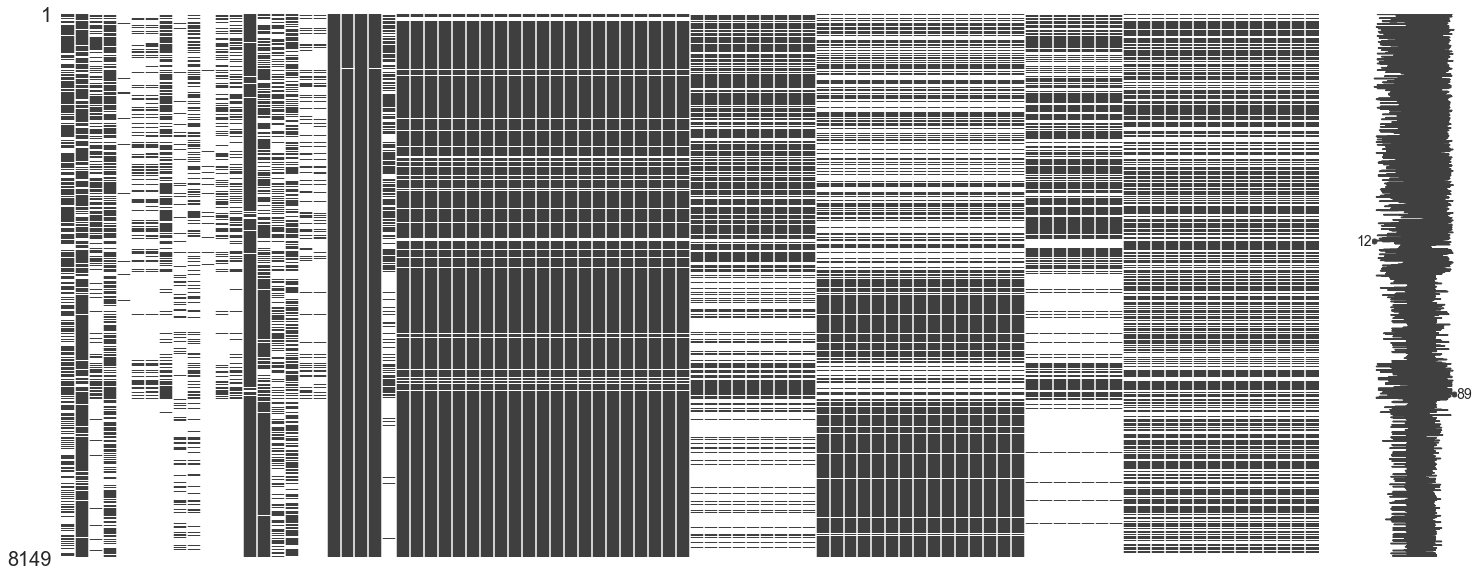

In [26]:
missingcols = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingcols])

In [27]:
drop_to_predict = df.loc[(df['\'Balcon\''] == 1) & (df['Nro_pisos']==1) & (df['Tipo'] == 'Casa')].index
#Se supone que debería ser nulo dado que ninguna casa con balcón debería tener un piso
drop_to_p2 = df.loc[(df['\'Balcon\''] == 1) & (df['Nro_pisos']==1) & (df['Anunciante'] == 'OPB GRUPO INMOBILIARIO ')].index
indx_to_drop = list(drop_to_predict) + list(drop_to_p2)
df.drop(indx_to_drop,axis=0, inplace=True)

#### Haremos un modelo para completar los nulos de Nro_pisos, para eso tendremos que ver las variables predictoras.

In [28]:
#En este modelo no vy a contar los pisos que sean mayores a 5, dada que la prob de que sea mayores a 5 y no estén registrados es poca
df['Nro_pisos'] = df['Nro_pisos'].apply(pd.to_numeric, errors='coerce')
to_drop_ = df[df['Nro_pisos']>6].index

In [29]:
x_cols = ['NroBanios','Dormitorios','Area_constr_m2','Area_total_m2','\'anx81tico\'','Tipo','Precio']
Y = df['Nro_pisos'].dropna() #Acá tendré mis target para train y test
index_train = Y.index 
X = df[x_cols] 
X = X.loc[index_train] #Acá tendré mis X para eñ train y test
X.drop(to_drop_,axis=0,inplace=True) #dropeo como quedamos arriba

In [30]:
X['\'anx81tico\''].fillna(0,inplace=True)
X.dropna(axis=0,inplace=True)

In [31]:
index_drop = X[X.Precio < 20000].index #Estos precios no son lógicos!!!
X.drop(index_drop,axis=0,inplace=True)

In [32]:
x_index = X.index
Y = Y.loc[x_index] #No necesito dropear las dos columnas, sino solo filtrar en la Y

In [33]:
#import dill
#dill.load_session('ParaModeloRF.db')

Agregamos esta variable pq creemos que puede ayudar al algoritmo

In [34]:
X['Dif_areas'] = X['Area_total_m2'] - X['Area_constr_m2']
X['Prop_areas'] = (X['Area_constr_m2']/X['Area_total_m2'])*100

#### Ahora, transformaremos las variables para el modelo

https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [36]:
#Usaremos LabelEncoder para Dormitorios y OneHot para distritos. Sí, es más fácil aplicar a mano el reemplazo para dormitorios,
#Pero en este caso, veremos cómo lo hace LabelEncoder.

LabelEncoder = LabelEncoder()
X['Dormitorios'] = LabelEncoder.fit_transform(X['Dormitorios'])

In [37]:
#Voy a ponerle mi criterio según cuántos pisos tiene o puede tener
X['Tipo'] = X['Tipo'].map({'Casa de campo':0,'Casa de Playa': 1, 'Casa en quinta':2, 'Casa de Playa en condominio':3, 
              'Casa en condominio':4,'Casa':5})

In [38]:
X.drop(2927,inplace=True)
Y.drop(2927,inplace=True)

#### En este caso normalizaremos la data, de tal forma que podamos trabajar mejor con el modelo de ML

In [39]:
from sklearn.preprocessing import normalize

In [40]:
X_to_norm = [X['Precio'],X['Area_constr_m2'],X['Area_total_m2'],X['Dif_areas'],X['Prop_areas']] 
X_to_norm = normalize(X_to_norm)
#Hasta acá hemos normalizado las columnas

X = X.assign(Precio = X_to_norm[0])
X = X.assign(Area_constr_m2 = X_to_norm[1])
X = X.assign(Area_total_m2 = X_to_norm[2])
X = X.assign(Dif_areas = X_to_norm[3])
X = X.assign(Prop_areas = X_to_norm[4])
#Agregamos al normalización a la data que vamos a entrenar y vemos cómo ha cambiado...
X.head(3)

,NroBanios,Dormitorios,Area_constr_m2,Area_total_m2,'anx81tico',Tipo,Precio,Dif_areas,Prop_areas
0,4.0,2,0.015481,0.009300,1.0,5.0,0.001541,0.003098,0.005468
1,5.0,4,0.012041,0.002836,0.0,5.0,0.000261,-0.003449,0.013944
2,5.0,3,0.021502,0.023528,0.0,5.0,0.003395,0.018442,0.003002


In [41]:
X.drop(["'anx81tico'"],axis=1,inplace=True)

In [42]:
#Dividiremos la data en train y test.
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 41)

In [43]:
X_train = X_train[X_train.columns].astype('float32')
X_test = X_test[X_test.columns].astype('float32')

###### Después de probar algunos modelos, nos quedamos con un RandomForest para predecir finalmente.

Básicamente, lo que nos ha dicho las pruebas internas ha sido que el mejor max_depth para DT es de 8 y para RF es de 12 (con el que alcanza un 65% de accuracy)

In [44]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

In [51]:
#Haremos GridSearch para buscar las combinatorias exactas de los parámetros.
rf_clf = RandomForestClassifier(max_depth=12,n_estimators=2000,criterion='entropy', n_jobs=-1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
rf_clf.score(X_test,y_test)

0.6715210355987055

In [47]:
dt_clf = DecisionTreeClassifier(max_depth=8)
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
print(dt_clf.tree_.value)

[[[4.370e+02 1.926e+03 1.203e+03 1.220e+02 1.500e+01 3.000e+00]]

 [[8.900e+01 8.190e+02 9.130e+02 9.300e+01 1.200e+01 2.000e+00]]

 [[8.600e+01 7.990e+02 7.570e+02 6.500e+01 8.000e+00 2.000e+00]]

 ...

 [[3.000e+00 5.100e+01 8.000e+00 4.000e+00 1.000e+00 0.000e+00]]

 [[1.000e+00 3.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00]]

 [[2.000e+00 4.800e+01 8.000e+00 2.000e+00 1.000e+00 0.000e+00]]]


In [53]:
rf_clf.score(X_test,y_test)
#Según esto, el que minimiza nuestra impureza es el criterio 'entropy', n_estimators: 250, max_depth:12

0.6715210355987055

In [54]:
importances = rf_clf.feature_importances_
cols = X_train.columns

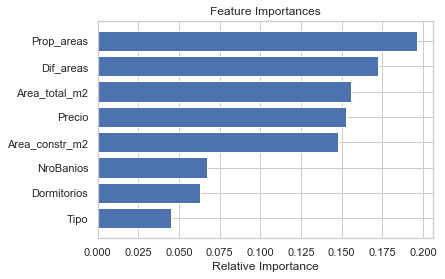

In [55]:
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align = 'center')
plt.yticks(range(len(indices)),[cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [56]:
import lightgbm as lg
lg_clf = lg.LGBMClassifier()
lg_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [57]:
lg_clf.score(X_test,y_test)

0.6577669902912622

Ahora, después de ver que el árbol de decisión es el mejor modelo para el problema. Haremos un ensamblado de árboles.
Usualmente es conocido como AdaBoost. Le meteremos 2000 iteraciones...

In [58]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=12), n_estimators=2000, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train,y_train)

y_pred = ada_clf.predict(X_test)

#We will try to evaluate the accuracy score
print("Test accuracy of the Decision Trees model:", accuracy_score(y_pred,y_test))

Test accuracy of the Decision Trees model: 0.6529126213592233


#### Ahora que ya tenemos nuestro modelo seleccionado, vamos a hacer la predicción.
Para eso tendremos que predecir la data nula, entonces extraemos:

In [59]:
df_p = df[df['Nro_pisos'].isna()]
X_predict = df_p[x_cols]
X_predict.dropna(axis=0,inplace=True)
X_predict['Tipo'] = X_predict['Tipo'].map({'Casa de campo':0,'Casa de Playa': 1, 'Casa en quinta':2, 'Casa de Playa en condominio':3, 
              'Casa en condominio':4,'Casa':5})
#index_drop = X_predict[X_predict.Precio<20000] ###LUEGO CAMBIAR Y CORREGIR _<<<<<<<<----------------------------------------
#X_predict.drop(index_drop,axis=0,inplace=True)
X_predict['Dif_areas'] = X_predict['Area_total_m2'] - X_predict['Area_constr_m2']
X_predict['Prop_areas'] = (X_predict['Area_constr_m2']/X_predict['Area_total_m2'])*100
X_predict['Dormitorios'] = LabelEncoder.fit_transform(X_predict['Dormitorios'])
X_predict_to_norm = [X_predict['Precio'],X_predict['Area_constr_m2'],X_predict['Area_total_m2'],X_predict['Dif_areas'],
                    X_predict['Prop_areas']]
X_predict_to_norm = normalize(X_predict_to_norm)
#Hasta acá hemos normalizado las columnas

X_predict = X_predict.assign(Precio = X_predict_to_norm[0])
X_predict = X_predict.assign(Area_constr_m2 = X_predict_to_norm[1])
X_predict = X_predict.assign(Area_total_m2 = X_predict_to_norm[2])
X_predict = X_predict.assign(Dif_areas = X_predict_to_norm[3])
X_predict = X_predict.assign(Prop_areas=X_predict_to_norm[4])
#dummy = pd.get_dummies(X_predict['Tipo'])
#X_predict_ = pd.concat([X_predict,dummy], axis=1)

X_predict.drop("'anx81tico'",axis=1,inplace=True)

#Ahora ya tengo mi X_predict final, para poder predecir lo que quisiera
X_predict.head(2)

,NroBanios,Dormitorios,Area_constr_m2,Area_total_m2,Tipo,Precio,Dif_areas,Prop_areas
15,4.0,3,0.018732,0.015216,1,0.010903,0.010461,0.008356
16,5.0,4,0.014944,0.005463,5,0.006555,0.000000,0.018569


In [60]:
X.head(2)

,NroBanios,Dormitorios,Area_constr_m2,Area_total_m2,Tipo,Precio,Dif_areas,Prop_areas
0,4.0,2,0.015481,0.009300,5.0,0.001541,0.003098,0.005468
1,5.0,4,0.012041,0.002836,5.0,0.000261,-0.003449,0.013944


Ahora, haremos la predicción de los datos entrenando con toda la data total y labelizada que tenemos usando nuestro mejor alg: random forests

In [61]:
rf_clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
Y_predict = rf_clf.predict(X_predict)

In [63]:
Y_predict

array([2., 3., 2., ..., 2., 2., 2.])

In [65]:
X_predict.index

Int64Index([  15,   16,   17,   19,   21,   23,   32,   44,   56,   68,
            ...
            8131, 8132, 8134, 8135, 8138, 8140, 8141, 8145, 8146, 8147],
           dtype='int64', length=2721)

In [66]:
#Acá tengo la data agregada, lista para poder reemplazar a los valores que quiera...
df_pred_pisos = pd.DataFrame(Y_predict)
df_pred_pisos.index = X_predict.index
df_pred_pisos.columns = ['Nro_pisos']

Ahora, uniré la data con la data original que tenía y por index...

In [67]:
#Ahora hemos unido el dataframe finalmente y nuestra cantidad de nulos ha disminuido!!!
df.loc[X_predict.index,'Nro_pisos'] = Y_predict

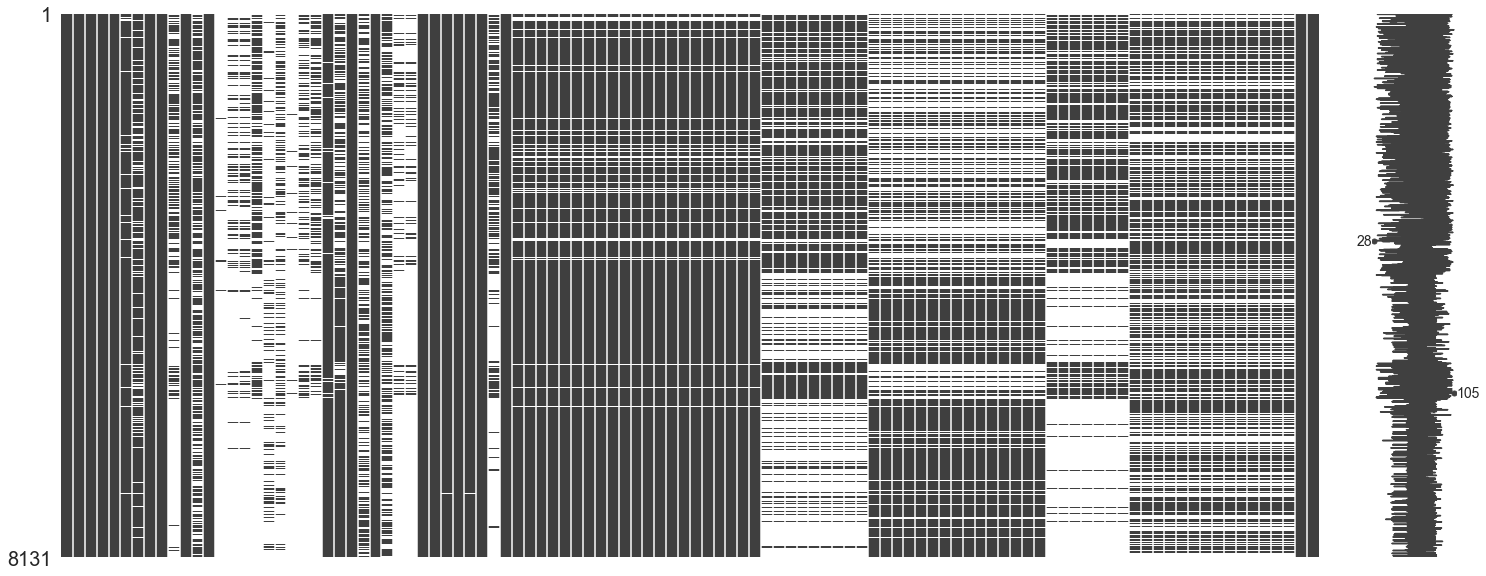

In [68]:
msno.matrix(df)

In [69]:
#Eliminar el Nro de pisos nulos.
drop_ = df[df['Nro_pisos'].isna() == True].index
df.drop(drop_, inplace=True)

In [70]:
df[((df['Descripcion'].str.contains('cochera')) & (df['Cocheras'].isna()))]

dict_cocheras = {}
df_ = df[df['Cocheras'].isna()]
for index,strings in df_['Descripcion'].items():
    position = strings.find('cocheras')
    if position != -1:
        dict_cocheras[index] = strings[position-2]
    else:
         pass
        
dict_replace_2 = {}
for key,value in dict_cocheras.items():
    if value.isdigit():
        dict_replace_2[key] = value
    else:
        pass

#Pasaremos este dict obtenido a un dataframe, para mejor visualización
df_rep = pd.DataFrame(dict_replace_2, index = [1] )
df_rep = df_rep.transpose()
df_rep.columns = ['Cocheras']

#Reemplazo los valores dentro del dataframe original:
df.loc[df_rep.index,'Cocheras'] = df_rep['Cocheras']

In [71]:
df['Cocheras'].fillna(0, inplace=True)
df['Cocheras']=df['Cocheras'].apply(pd.to_numeric, errors='coerce')

Por cuestiones prácticas...

In [72]:
df.drop('Disposicion',axis=1,inplace=True)

In [73]:
df['Estado de Inmueble'].fillna('NoEspecifica', inplace=True)

In [74]:
df.drop('Fila',axis=1,inplace=True)

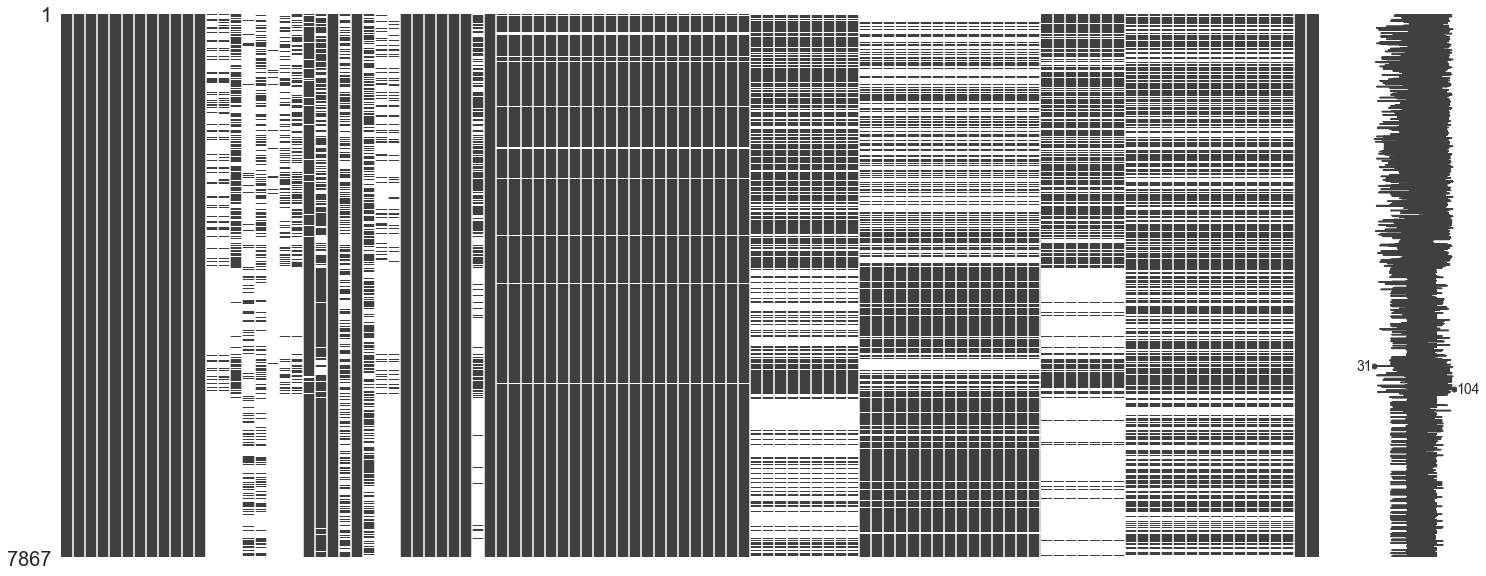

In [75]:
msno.matrix(df)

Las variables Frente y Fondo son en sí los metros cuadrados que tiene la casa de frente y de fondo, respectivamente...

In [76]:
#Por motivos prácticos, vamos a eliminar estas variables:
df.drop(['Fondo','Frente'],axis=1,inplace=True)

In [77]:
df['Luminosidad'].fillna('NoEspecifica',inplace=True)

In [78]:
#----------------------------------------------------------------------------------------------------
#Elimino la columna por la cantidad de nulos que existe... (tal vez se puedan reemplazar a partir del geohash de la zona)
df.drop(['Mantenimiento'],axis=1,inplace=True)

In [79]:
#Se asume esto
df['Mascotas'].fillna('Si',axis=0,inplace=True)

In [80]:
df.drop('Medidas',axis=1,inplace=True)

In [81]:
df['Pisos_construibles'].isna().sum() #Se puede reemplazar buscando en la descripcion
df.drop('Pisos_construibles',axis=1,inplace=True)

In [82]:
#Las casas que no tienen cocheras, no tienen tipo de cocheras ni tipo de puerta de cochera
index = df[(df.Cocheras == 0)].index
df.loc[index,'TipoCochera'] = 'NoTiene'
df.loc[index,'TipoPuertaCochera'] = 'NoTiene'

In [83]:
df.TipoCochera.fillna('NoEspecifica',inplace=True)
df.drop('TipoPuertaCochera',inplace=True,axis=1)

In [84]:
###Dropeamos las filas que no tienen Precio especificado...
index = df[df['Precio'].isna()].index
df.drop(index,inplace=True,axis=0)

Explicando la variable referencia: Si bien nos puede dar buena data acerca de qué tan cerca a avenidas concurridas está la casa, eliminaremos la columna temporalmente. En futuras versiones de este análisis podremos reutilizarla.

In [85]:
df.drop('Referencia',axis=1,inplace=True)

In [86]:
#Por fines prácticos, también eliminaremos la urbanización. En un futuro tendremos la longitud y latitud de las casas (o zona de referencia)
df.drop('Urbaniz',axis=1,inplace=True)

In [87]:
df['Uso_profesional'].fillna('NoEspecifica',inplace=True)

In [88]:
index = df[(df['Precio']<20000)].index 
df.drop(index,axis=0,inplace=True)

In [89]:
#No especifica el uso comercial en sí
df.Uso_comercial.fillna('NoEspecifica',inplace=True)

### IMPORTANT CAVEAT!

In [90]:
##### POR EL MOMENTO ELIMINARE LA VARIABLE DE AREA_TERRENO_M2. EVALUARE ESTO ANTES DE TENER EL MODELO
df.drop('Area_Terreno_m2',inplace=True,axis=1)

#### Haré el reemplazo de las variables dummie, cada Nan se reemplazará con otra categoría.

In [91]:
dummies_col = []
for col in df.columns:
    if df[col].isna().any():
        dummies_col.append(col)
        print(col,'tiene',df[col].isna().sum())

Area_total tiene 1
Area_total_m2 tiene 1
'Cuarto de servicio' tiene 223
'Deposito' tiene 223
'Terraza' tiene 223
'Kitchenette' tiene 223
'Sala de estar' tiene 223
'Sotano' tiene 223
'Patio' tiene 223
'anx81tico' tiene 223
'Comedor diario' tiene 223
'Comedor' tiene 223
'Banio de servicio' tiene 223
'Jardanxadn Interno' tiene 223
'Walking Closet' tiene 223
'Escritorio' tiene 223
'Cocina' tiene 223
'Banio independiente' tiene 223
'Lavanderanxada' tiene 223
'Balcon' tiene 223
'Sala' tiene 223
'Closet' tiene 223
'Banio de visitas' tiene 223
'Agua' tiene 3663
'Guardiananxada' tiene 3663
'Internet' tiene 3663
'Luz' tiene 3663
'Cable' tiene 3663
'Servicio de Limpieza' tiene 3663
'Conexion a gas' tiene 3663
'Sistema de seguridad' tiene 3663
'Telefono' tiene 3663
'Areadeportiva' tiene 2665
'Piscina' tiene 2665
'Solarium' tiene 2665
'Sala de internet' tiene 2665
'Sala de cine' tiene 2665
'Jardanxadn' tiene 2665
'Parque interno' tiene 2665
'Guarderanxada' tiene 2665
'anx81reas verdes' tiene 2665
'

In [92]:
for d_col in dummies_col:
    df[d_col].fillna('NoEspecifica',inplace=True)

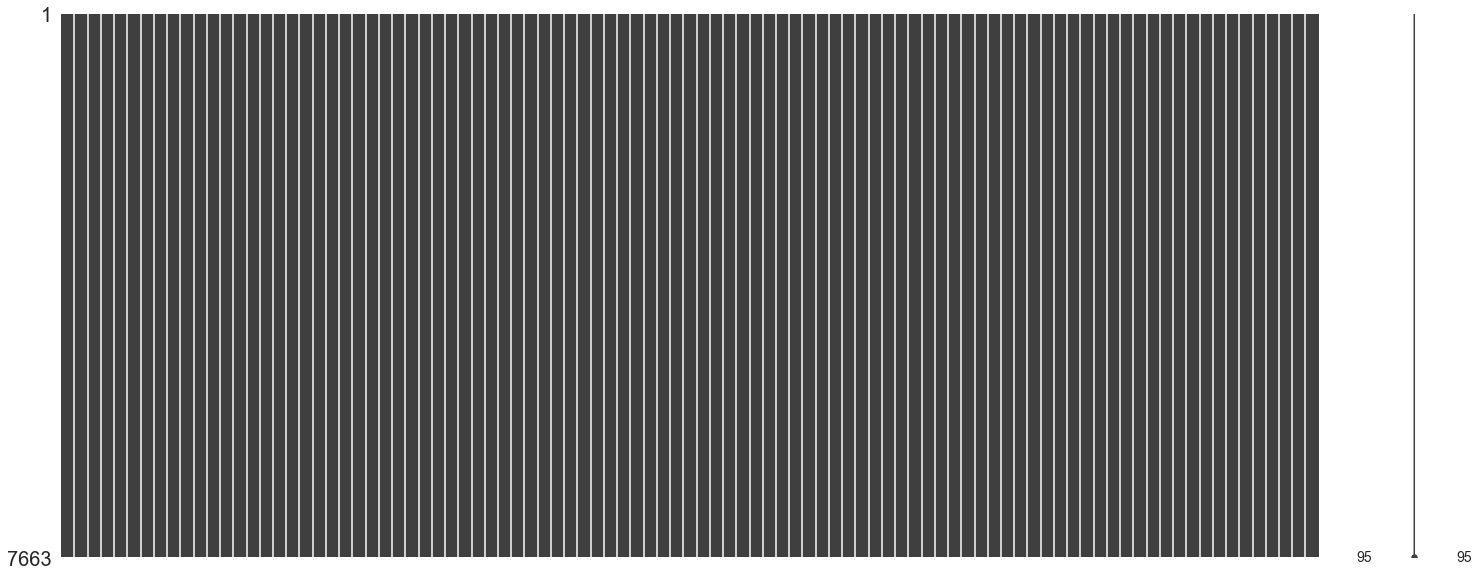

In [93]:
msno.matrix(df)

In [96]:
df.to_csv('data_para_preprocessing.csv')